In [1]:
import pandas as pd
import numpy as np
import random
import math
reviews = pd.read_csv("house-votes-84.csv")

In [2]:
class Node:
    def __init__(self, ntype):
        self.ntype = ntype
        self.children = {}

In [3]:
reviews.drop("Label", axis = 1, inplace = True) 
reviews.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,Party?
0,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y,republican
1,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?,republican
2,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n,democrat
3,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y,democrat
4,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y,democrat


In [4]:
def moderef(column):
    temp_dict = {}
    for val1, val2 in reviews[[column, 'Party?']].values:
        if val1 == '?': continue
        if val2 not in temp_dict: temp_dict[val2] = {}
        if val1 not in temp_dict[val2]: temp_dict[val2][val1] = 1
        else: temp_dict[val2][val1] = temp_dict[val2][val1] + 1
    return temp_dict

In [5]:
def condense(diction):
    cond = {}
    for k in diction:
        if diction[k]['n'] >= diction[k]['y']: cond[k] = 'n'
        else: cond[k] = 'y'
    return cond

In [6]:
def construct_dict():
    values = {}
    for label in list(reviews.columns.values):
        if label == 'Party?': continue
        values[label] = condense(moderef(label))
    return values
mgc_dict = construct_dict()

In [7]:
def fill_in(df):
    for i in list(df.index):
        for j in list(df.columns.values):
            if df.iloc[i][j] == '?': df.iloc[i][j] = mgc_dict[j][df.iloc[i]['Party?']]
    return df

In [8]:
r_mod = fill_in(reviews)
r_mod.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,Party?
0,n,y,n,y,y,y,n,n,n,y,n,y,y,y,n,y,republican
1,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,y,republican
2,y,y,y,n,y,y,n,n,n,n,y,n,y,y,n,n,democrat
3,n,y,y,n,n,y,n,n,n,n,y,n,y,n,n,y,democrat
4,y,y,y,n,y,y,n,n,n,n,y,n,y,y,y,y,democrat


In [9]:
def allPartiesMatch(D):
    classes = list(D['Party?'])
    for i in range (0, len(classes)-1):
        if classes[i] != classes[i+1]: return (False, None)
    return (True, classes[0])

In [10]:
def log(num):
    if num == 0: return 0
    return math.log(num, 2)

In [11]:
def h(tupe):
    rep, dem = tupe[0], tupe[1]
    total = rep+dem
    return -1*((rep/total)*log(rep/total) + (dem/total)*log(dem/total))

In [12]:
def exp_ent_helper(attr, reviews):
    attr_dict = {} #dictionary points to tuple
    for val1, val2 in reviews[[attr, 'Party?']].values:
        if val1 not in attr_dict: 
            if val2 == 'republican': attr_dict[val1] = (1,0)
            else: attr_dict[val1] = (0,1)
        else: 
            if val2 == 'republican': attr_dict[val1] = (attr_dict[val1][0] + 1, attr_dict[val1][1])
            else: attr_dict[val1] = (attr_dict[val1][0], attr_dict[val1][1] + 1)
    return (attr_dict, len(reviews[attr]))

In [13]:
def exp_ent(attr, D):
    attr_dict, total = exp_ent_helper(attr, D)
    expent = 0
    for att in attr_dict:
        multiplier = (attr_dict[att][0] + attr_dict[att][1]) / total
        expent = expent + h(attr_dict[att])*multiplier
    return expent

In [14]:
def find_best_attribute(D):
    entr = math.inf
    lbl = None
    for label in list(D.columns.values):
        if label == 'Party?': continue
        ee = exp_ent(label, D)
        if ee < entr:
            entr = ee
            lbl = label
    return lbl

In [15]:
def decisionTreeLearn(D):
    ee0, classifier = allPartiesMatch(D)
    if ee0: #expected entropy = 0
        tnode = Node('leaf')
        tnode.classif = classifier
        return tnode
    f = find_best_attribute(D)
    node = Node('internal')
    node.name = f
    #values, num = exp_ent_helper(f, D)
    for value in ['y', 'n']:
        D_prime = D[D[f] == value]
        if D_prime.size == 0 or len(D_prime) == len(D):
            tnode = Node('leaf')
            tnode.classif = random.choice(['republican', 'democrat'])
            node.children[value] = tnode
        else:
            child = decisionTreeLearn(D_prime)
            node.children[value] = child
    return node

In [16]:
def printTree(node, level = 0):
    if node.ntype == 'leaf': ret = "\t"*level+ node.classif +'\n'
    else: ret = "\t"*level + node.name +'\n'
    for value in node.children:
        ret += '\t'*level + value + '\n' + '\n' + printTree(node.children[value], level+1)
    return ret

In [17]:
def classify(tree, row):
    if tree.ntype == 'leaf': return tree.classif
    return classify(tree.children[row[tree.name]], row)

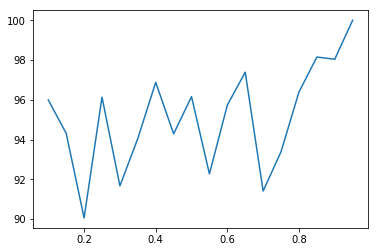

In [46]:
import matplotlib.pyplot as plt

i = 0.1
acc_list = []
x_list = []
while i<0.99:
    msk = np.random.rand(len(r_mod)) < i
    train = r_mod[msk]
    test = r_mod[~msk]

    nd = decisionTreeLearn(train)

    #avg = 0
    #for i in range(0, 50):
    
    
    counter = 0
    for index, row in test.iterrows():
        if classify(nd, row) == row['Party?']: counter = counter + 1
    acc_list.append((counter/test.shape[0])*100)
    x_list.append(i)
    #print((counter/test.shape[0])*100, '% accuracy')
    #print(printTree(nd))
    i = i + 0.05

plt.plot(x_list, acc_list)
plt.show()